This notebook consists of Exploratory Data Analysis on the titanic dataset. The aim is to build a classification model to predict if a passenger would survive the titanic disaster or not. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from statistics import mean

In [2]:
### Loading the training and testing datasets
train = pd.read_csv('../input/titanic/train.csv',sep = ',')
test = pd.read_csv('../input/titanic/test.csv',sep = ',')
print(train.describe(),"Description of training data")

print(train.head(),"Snapshot of training data")

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200   Description of training data
   PassengerId  Survived  Pclass  \
0            1  

Survival variable is the response variable and the rest are predictor variables. Out of the predictor variables Passenger ID, Passenger Name,Fare and Ticket Number probably do not matter or help in predicting if they would survive or not. 


In [3]:
train = train[['Survived','Pclass','Sex','Age','SibSp','Parch','Cabin','Embarked']]
test = test[['Pclass','Sex','Age','SibSp','Parch','Cabin','Embarked']]

train = train.dropna(subset = ['Embarked'])

### One Hot Encoding the variables
train = pd.concat([train,train.Sex.str.get_dummies()],axis =1)
train = pd.concat([train,train.Embarked.str.get_dummies()],axis =1)
test = pd.concat([test,test.Sex.str.get_dummies()],axis=1)
test = pd.concat([train,train.Embarked.str.get_dummies()],axis =1)

In [4]:
### Checking for NA values in the dataset and dealing with them
print("Number of NA values in each column:")
print(train.isnull().sum(axis = 0))
train_data = train
test_data = test
train_data_only_na_values = train_data[np.isnan(train_data.Age)]
print(train_data_only_na_values.head())

Number of NA values in each column:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Cabin       687
Embarked      0
female        0
male          0
C             0
Q             0
S             0
dtype: int64
    Survived  Pclass     Sex  Age  SibSp  Parch Cabin Embarked  female  male  \
5          0       3    male  NaN      0      0   NaN        Q       0     1   
17         1       2    male  NaN      0      0   NaN        S       0     1   
19         1       3  female  NaN      0      0   NaN        C       1     0   
26         0       3    male  NaN      0      0   NaN        C       0     1   
28         1       3  female  NaN      0      0   NaN        Q       1     0   

    C  Q  S  
5   0  1  0  
17  0  0  1  
19  1  0  0  
26  1  0  0  
28  0  1  0  


Number of people survived:  52
Number of people not survived:  125


Text(0.5, 1.0, 'Count Plot of Survived People according to embarkment point')

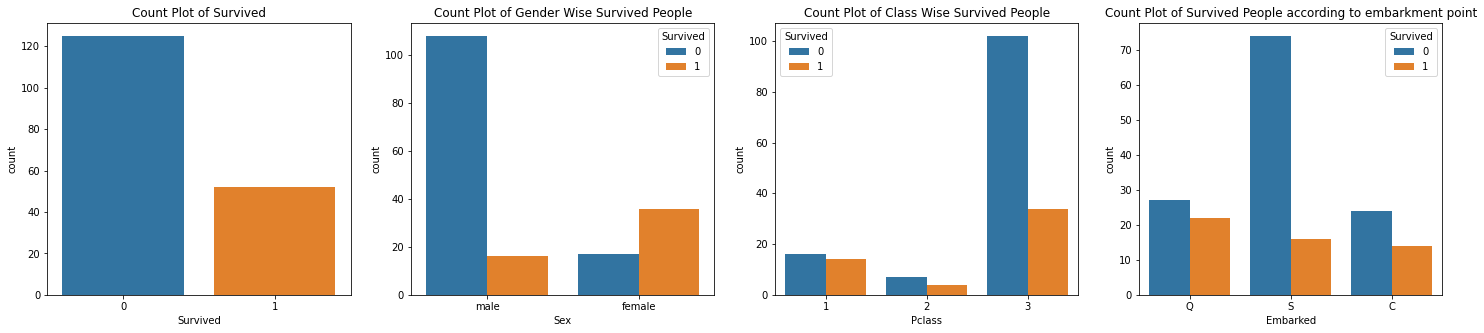

In [5]:
### Plotting details about data pertaining to column where Age is missing
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(25,5))
sns.countplot(x='Survived',data=train_data_only_na_values,ax=ax1)
ax1.set_title('Count Plot of Survived')
print("Number of people survived: ",np.count_nonzero(train_data_only_na_values[['Survived']]))
print("Number of people not survived: ",np.count_nonzero(train_data_only_na_values[['Survived']]==0))

### Looking at the percentage of samples from each class it does not seem like there is a class imbalance

### Plot - 2 is going to show us the distribution of the survival variable with respect to other categorical variables
sns.countplot(x='Sex',hue='Survived',data=train_data_only_na_values,ax=ax2)
ax2.set_title('Count Plot of Gender Wise Survived People')
sns.countplot(x='Pclass',hue='Survived',data=train_data_only_na_values,ax=ax3)
ax3.set_title('Count Plot of Class Wise Survived People')
sns.countplot(x='Embarked',hue='Survived',data=train_data_only_na_values,ax=ax4)
ax4.set_title('Count Plot of Survived People according to embarkment point')

Based on the plots below the values of age seem to be missing at random and do not seem to exhibit any specific pattern. Hence we can proceed forward with imputation techniques
We will be using the KNN imputation technique. The reason for using such a technique is that the missing values are present in the age variable. We believe that given all other variables are similar the ages might also be similar. Hence we will be using KNN imputation technique to find the nearest neighbours in the feature space

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

### We will drop the columns Sex and Embarked since they are already one-hot encoded
train_data = train_data.drop(['Sex'],axis=1)
train_data = train_data.drop(['Embarked'],axis=1)

### We will drop the Cabin column since more than 60% of the values are missing in the column
train_data = train_data.drop(['Cabin'],axis=1)
print(train_data.head())
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns = train_data.columns)
train_data.head()

   Survived  Pclass   Age  SibSp  Parch  female  male  C  Q  S
0         0       3  22.0      1      0       0     1  0  0  1
1         1       1  38.0      1      0       1     0  1  0  0
2         1       3  26.0      0      0       1     0  0  0  1
3         1       1  35.0      1      0       1     0  0  0  1
4         0       3  35.0      0      0       0     1  0  0  1


,Survived,Pclass,Age,SibSp,Parch,female,male,C,Q,S
0,0.0,1.0,0.271174,0.125,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.472229,0.125,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.321438,0.000,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.434531,0.125,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.434531,0.000,0.0,0.0,1.0,0.0,0.0,1.0


In [7]:
### KNN Imputation Technique to impute NA values of the Age column
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10)
new_train_data = pd.DataFrame(imputer.fit_transform(train_data),columns = train_data.columns)
print(new_train_data)

     Survived  Pclass       Age  SibSp     Parch  female  male    C    Q    S
0         0.0     1.0  0.271174  0.125  0.000000     0.0   1.0  0.0  0.0  1.0
1         1.0     0.0  0.472229  0.125  0.000000     1.0   0.0  1.0  0.0  0.0
2         1.0     1.0  0.321438  0.000  0.000000     1.0   0.0  0.0  0.0  1.0
3         1.0     0.0  0.434531  0.125  0.000000     1.0   0.0  0.0  0.0  1.0
4         0.0     1.0  0.434531  0.000  0.000000     0.0   1.0  0.0  0.0  1.0
..        ...     ...       ...    ...       ...     ...   ...  ...  ...  ...
884       0.0     0.5  0.334004  0.000  0.000000     0.0   1.0  0.0  0.0  1.0
885       1.0     0.0  0.233476  0.000  0.000000     1.0   0.0  0.0  0.0  1.0
886       0.0     1.0  0.279970  0.125  0.333333     1.0   0.0  0.0  0.0  1.0
887       1.0     0.0  0.321438  0.000  0.000000     0.0   1.0  1.0  0.0  0.0
888       0.0     1.0  0.396833  0.000  0.000000     0.0   1.0  0.0  1.0  0.0

[889 rows x 10 columns]


In [8]:
### We will inverse our transform to plot for EDA
train_data_final = pd.DataFrame(scaler.inverse_transform(new_train_data),columns = new_train_data.columns)

train_data_final[['Sex']] = 'Male'
idx = train_data_final.index[train_data_final['male']==0.0]
train_data_final.loc[idx,'Sex'] = 'Female'

train_data_final[['Embarked']] = 'C'
idx = train_data_final.index[(train_data_final['C']==0.0) & (train_data_final['Q']==0.0)]
train_data_final.loc[idx,'Embarked'] = 'S'
idx = train_data_final.index[(train_data_final['C']==0.0) & (train_data_final['S']==0.0)]
train_data_final.loc[idx,'Embarked'] = 'Q'

print(train_data_final.head())

   Survived  Pclass   Age  SibSp  Parch  female  male    C    Q    S     Sex  \
0       0.0     3.0  22.0    1.0    0.0     0.0   1.0  0.0  0.0  1.0    Male   
1       1.0     1.0  38.0    1.0    0.0     1.0   0.0  1.0  0.0  0.0  Female   
2       1.0     3.0  26.0    0.0    0.0     1.0   0.0  0.0  0.0  1.0  Female   
3       1.0     1.0  35.0    1.0    0.0     1.0   0.0  0.0  0.0  1.0  Female   
4       0.0     3.0  35.0    0.0    0.0     0.0   1.0  0.0  0.0  1.0    Male   

  Embarked  
0        S  
1        C  
2        S  
3        S  
4        S  


Number of people survived:  340
Number of people not survived:  549


Text(0.5, 1.0, 'Count Plot of Survived People depending on number of siblings')

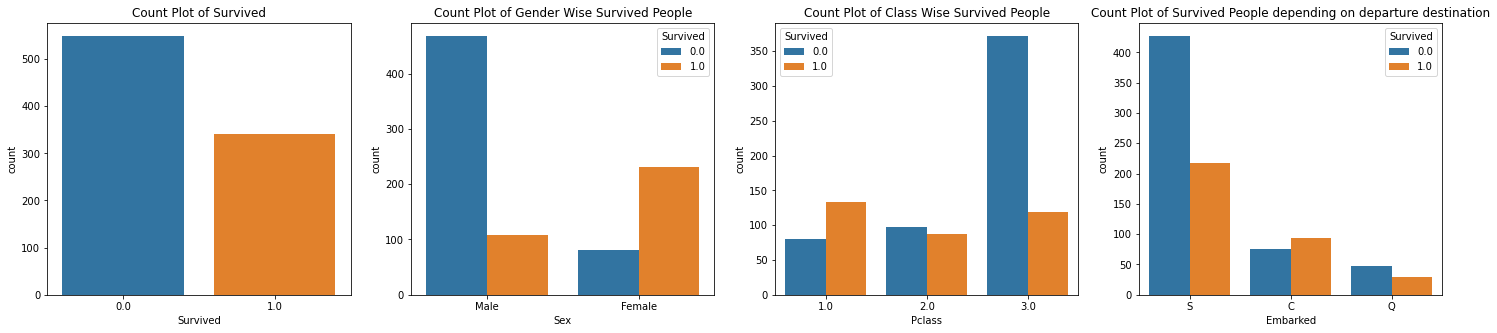

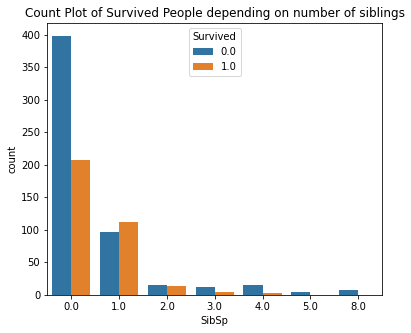

In [9]:
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(25,5))
sns.countplot(x='Survived',data=train_data_final[['Survived']],ax=ax1)
ax1.set_title('Count Plot of Survived')
print("Number of people survived: ",np.count_nonzero(train_data_final[['Survived']]))
print("Number of people not survived: ",np.count_nonzero(train_data_final[['Survived']]==0))

sns.countplot(x='Sex',hue='Survived',data=train_data_final,ax=ax2)
ax2.set_title('Count Plot of Gender Wise Survived People')
sns.countplot(x='Pclass',hue='Survived',data=train_data_final,ax=ax3)
ax3.set_title('Count Plot of Class Wise Survived People')
sns.countplot(x='Embarked',hue='Survived',data=train_data_final,ax=ax4)
ax4.set_title('Count Plot of Survived People depending on departure destination')

plt.figure(figsize=(6,5))
fig1 = sns.countplot(x='SibSp',hue='Survived',data=train_data_final)
fig1.set_title('Count Plot of Survived People depending on number of siblings')

### Plot - 1 is going to show us the distribution of the survival variable
Looking at the percentage of samples from each class it does not seem like there is a class imbalance. The percentage distribution of the response variable is roughly 60% and 40%, hence we will not need to modify the training data by using any sampling technique

### Plot - 2 is going to show us the distribution of the survival variable with respect to other categorical variables
* The first plot shows us the distribution of people survived according to their gender. Looking at the distribution, it seems a large number of males did not survive the disaster. We can hypothesize that children and spouses of the male members might have boarded the rescue boats before the men and hence a lot of men could have died because they could not get on to the rescue boats at the right time
* The second plot shows us the distribution of survival according to the class travelled. A large number of people travelling by class 3 did not survive the disaster. 
* The third plot shows us the distribution of survival according to the departure destination. A large number of people embarking from destination S seem to have not survived the disaster. It is unusual how source of embarkment affects survival. It is possible a lot of members travelling from destination S were males and hence the survival rate seems to be low.
* The fourth and final plot is about how the number of siblings affect survival. A large number of people with no sibilings or spouses seemed to have not survived the disaster.


<Figure size 432x288 with 0 Axes>

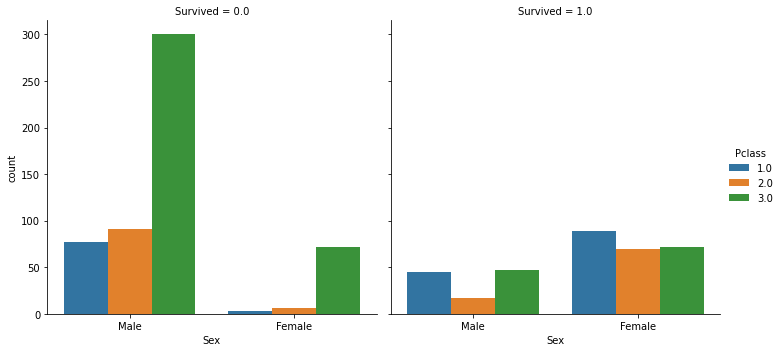

<Figure size 432x288 with 0 Axes>

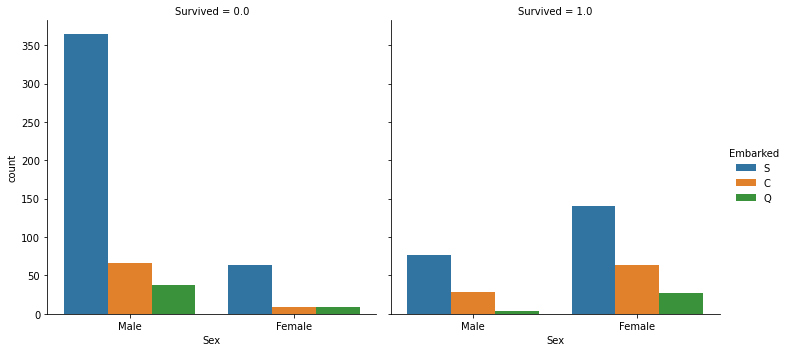

In [10]:
### Plot - 3 is going to include 3 variables 
plt.figure()
sns.catplot(x='Sex',hue='Pclass',col='Survived',kind='count',data=train_data_final)
plt.figure()
sns.catplot(x='Sex',hue='Embarked',col='Survived',kind='count',data=train_data_final)

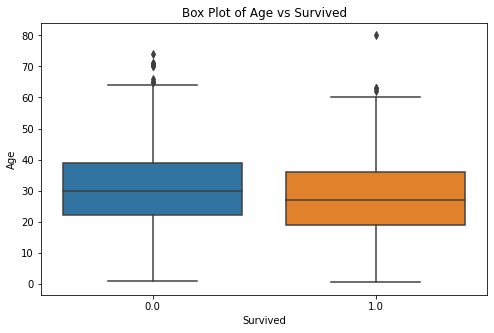

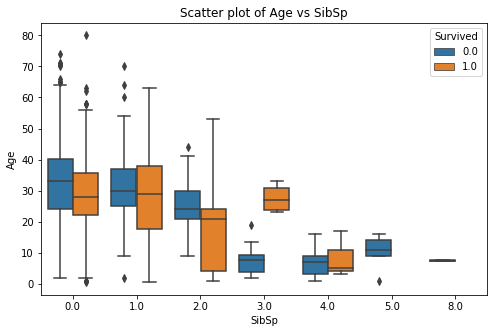

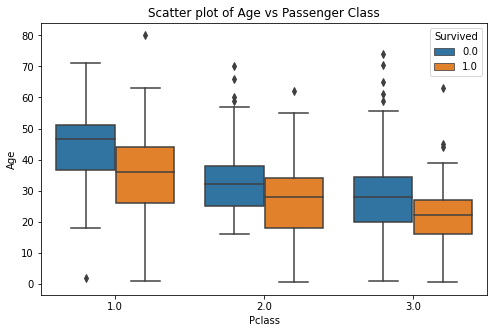

<Figure size 576x360 with 0 Axes>

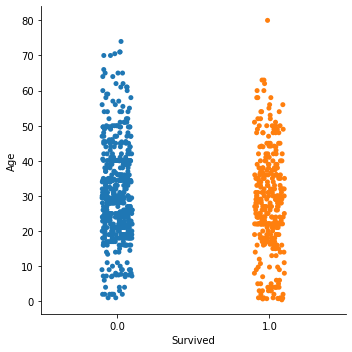

In [11]:
### Plot - 4 is going to be the distribution of survived with respect to continuous variables like Age and Number of Children/Spouses
plt.figure(figsize=(8,5))
fig1 = sns.boxplot(x='Survived',y='Age',data=train_data_final)
fig1.set_title('Box Plot of Age vs Survived')
plt.figure(figsize=(8,5))
fig2 = sns.boxplot(x='SibSp',y='Age',hue='Survived',data=train_data_final)
fig2.set_title('Scatter plot of Age vs SibSp')
plt.figure(figsize=(8,5))
fig3 = sns.boxplot(x='Pclass',y='Age',hue='Survived',data=train_data_final)
fig3.set_title('Scatter plot of Age vs Passenger Class')
plt.figure(figsize=(8,5))
fig4 = sns.catplot(x='Survived',y='Age',data=train_data_final)

Writing thoughts about observation from plots

## Model - 1: Logistic Regression

In [39]:
### We will do a 10 fold cross validation repeated over 5 random seeds. We will then average the results for these 5 random seeds and use the average to compare different models
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statistics import stdev
X = new_train_data[['Pclass','SibSp','Age','male','female','C','Q','S']]
Y = new_train_data.Survived

logisticRegressionModel = LogisticRegression()
cv_results_lr = cross_val_score(logisticRegressionModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_lr)*100,"+-",stdev(cv_results_lr)*100)

Mean Accuracy: 79.97957099080695 +- 3.7635363401621666


We will first select hyperparameters for our Random Forest Model using Random Search and then further refine it using grid search

## Model - 2: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

randomForestModel = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = randomForestModel, scoring = 'accuracy', 
                               param_distributions = random_grid, n_iter = 100, 
                               cv = 10)
rf_random.fit(X, Y)
print(rf_random.best_params_)

In [ ]:
from sklearn.model_selection import GridSearchCV
### We can now try to do a grid search to fine tune the parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1800, stop = 2200, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(25, 30, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

randomForestModel = RandomForestClassifier()
rf_random = GridSearchCV(estimator = randomForestModel, scoring = 'accuracy', 
                         param_grid = random_grid,
                         cv = 10)
rf_random.fit(X, Y)
print(rf_random.best_params_)

In [13]:
from sklearn.ensemble import RandomForestClassifier
randomForestModel = RandomForestClassifier(n_estimators=1933,max_depth=25,max_features='auto')
cv_results_rf = cross_val_score(randomForestModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_rf)*100,"+-",stdev(cv_results_rf)*100)

Mean Accuracy: 82.11567926455567 +- 2.611519231634358


## Model - 3: Gradient Boosting Machines (GBM)

In [ ]:
### Gradient Boosting Model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Number of trees for Gradient Boosting
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

gradientBoostingModel = GradientBoostingClassifier()
gb_random = RandomizedSearchCV(estimator = gradientBoostingModel, scoring = 'accuracy', 
                         param_distributions = random_grid, n_iter = 50,
                         cv = 10)
gb_random.fit(X, Y)
print(gb_random.best_params_)

In [14]:
from xgboost import XGBClassifier
gradientBoostingModel = XGBClassifier(objective='binary:logistic')
# Number of trees for Gradient Boosting
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
gb_random = RandomizedSearchCV(estimator = gradientBoostingModel, scoring = 'accuracy', 
                         param_distributions = random_grid, n_jobs=4, n_iter = 100,
                         cv = 10)
gb_random.fit(X, Y)
print(gb_random.best_params_)

NameError: name 'RandomizedSearchCV' is not defined

In [20]:
### We can now try to do a grid search to fine tune the parameters
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
# Number of trees for Gradient Boosting
n_estimators = [int(x) for x in np.linspace(start = 1100, stop = 1200, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 25, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

gradientBoostingModel = XGBClassifier(objective='binary:logistic')
gb_random = GridSearchCV(estimator = gradientBoostingModel, scoring = 'accuracy', 
                         param_grid = random_grid,
                         cv = 10)
gb_random.fit(X, Y)
print(gb_random.best_params_)

{'max_depth': 23, 'n_estimators': 1166}


In [21]:
gradientBoostingModel = XGBClassifier(objective='binary:logistic',n_estimators = 1166,max_depth = 23)
cv_results_gbm = cross_val_score(gradientBoostingModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_gbm)*100,"+-",stdev(cv_results_gbm)*100)

Mean Accuracy: 81.20914198161388 +- 3.354173068790333


## Model - 4: Support Vector Machines (SVM)

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
### Regularization Parameter for SVM
C = [0.1,0.5,0.75,1.0,1.25,1.5,2.0]
### Type of Kernel to be used for SVM
kernel = ['linear','poly','rbf','sigmoid']
gamma = ['auto','scale']

svmModel = SVC()
random_grid = {'C': C,
               'kernel': kernel,
               'gamma':gamma}
svm_random = RandomizedSearchCV(estimator = svmModel, scoring = 'accuracy', 
                         param_distributions = random_grid, n_iter = 50,
                         cv = 10)
svm_random.fit(X,Y)
print(svm_random.best_params_)

{'kernel': 'poly', 'gamma': 'scale', 'C': 0.75}


In [27]:
### Regularization Parameter for SVM
C = [float(x) for x in np.linspace(start = 0.5,stop = 1.0,num = 50)]
### Type of Kernel to be used for SVM
kernel = ['linear','poly','rbf','sigmoid']
gamma = ['auto','scale']

svmModel = SVC()
random_grid = {'C': C,
               'kernel': kernel,
               'gamma':gamma}
svm_random = GridSearchCV(estimator = svmModel, scoring = 'accuracy', 
                         param_grid = random_grid,
                         cv = 10)
svm_random.fit(X,Y)
print(svm_random.best_params_)

{'C': 0.673469387755102, 'gamma': 'scale', 'kernel': 'poly'}


In [30]:
svmModel = SVC(C = 0.673469387755102, gamma = 'scale',kernel = 'poly')
cv_results_svm = cross_val_score(svmModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_svm)*100,"+-",stdev(cv_results_svm)*100)

Mean Accuracy: 81.09805924412666 +- 4.3853988890012445


## Model - 5: K-Nearest Neighbours (KNN)

In [43]:
from sklearn.neighbors import KNeighborsClassifier
### Number of nearest neighbours parameter for KNN
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 50, num = 50)]
### Weight of neighbours
weights = ['uniform','distance']
leaf_size = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
knnModel = KNeighborsClassifier()
random_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'leaf_size': leaf_size}
knn_random = RandomizedSearchCV(estimator = knnModel, scoring = 'accuracy', 
                         param_distributions = random_grid, n_iter = 500,
                         cv = 10)
knn_random.fit(X,Y)
print(knn_random.best_params_)

{'weights': 'uniform', 'n_neighbors': 3, 'leaf_size': 3}


In [44]:
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
### Weight of neighbours
weights = ['uniform','distance']
leaf_size = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
knnModel = KNeighborsClassifier()
random_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'leaf_size': leaf_size}
knn_random =GridSearchCV(estimator = knnModel, scoring = 'accuracy', 
                         param_grid = random_grid,
                         cv = 10)
knn_random.fit(X,Y)
print(knn_random.best_params_)

{'leaf_size': 2, 'n_neighbors': 3, 'weights': 'uniform'}


In [51]:
knnModel = KNeighborsClassifier(n_neighbors = 3, leaf_size = 2, weights = 'uniform')
cv_results_knn = cross_val_score(knnModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_knn)*100,"+-",stdev(cv_results_knn)*100)

Mean Accuracy: 83.35546475995915 +- 3.450027788868553
